In [1]:
import random
import numpy as np
import cv2
import os
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from os.path import join
from os import listdir
from torchsummary import summary
import time
import zipfile
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

e:\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
display_number = 2                                     # plt로 디스플레이할 이미지의 개수
residual_output_paths = '/content/residuals'           # 잔차 이미지를 저장할 폴더
noisy_image_paths = '/content/dataset/train/scan'
clean_image_paths = '/content/dataset/train/clean'

output = False                                         # residual을 파일로 출력할지 여부

def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path


# 데이터셋 로드 및 전처리
noisy_dataset = CustomDatasetTest(noisy_image_paths)
clean_dataset = CustomDatasetTest(clean_image_paths)

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=False)

In [ ]:
# residual volume 1

residuals_1 = torch.Tensor(5000, 512, 512, 3)

for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):
    residual_image = noisy_image[0] - clean_image[0]
    residuals_1[i] = residual_image
    if(i<display_number):
        plt.subplot(1,3,1)
        plt.title("noisy_image")
        plt.imshow(noisy_image[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("clean_image")
        plt.imshow(clean_image[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("residual_image")
        plt.imshow(residual_image)
        plt.axis('off')
        plt.show()

    if output:
        output_filename = noisy_image_path[0]
        residual_filename = residual_output_paths + '/' + output_filename.split('\\')[-1][:-4].replace('\\',"/") + '.png'
        cv2.imwrite(residual_filename, np.array(residual_image))

    if(i==4999):
        break
    
avg_residual_1 = torch.mean(residuals_1,axis=0).type(torch.uint8)
cv2.imwrite("/content/residuals/avg_residual_1.png",avg_residual_1)


In [4]:
# residual volume 2

residuals_2 = torch.Tensor(5000, 512, 512, 3)

for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):

    if(i<=4999):
        continue

    residual_image = noisy_image[0] - clean_image[0]
    residuals_2[i-5000] = residual_image
    if(i<display_number):
        plt.subplot(1,3,1)
        plt.title("noisy_image")
        plt.imshow(noisy_image[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.title("clean_image")
        plt.imshow(clean_image[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.title("residual_image")
        plt.imshow(residual_image)
        plt.axis('off')
        plt.show()

    if output:
        output_filename = noisy_image_path[0]
        residual_filename = residual_output_paths + '/' + output_filename.split('\\')[-1][:-4].replace('\\',"/") + '.png'
        cv2.imwrite(residual_filename, np.array(residual_image))
    
avg_residual_2 = torch.mean(residuals_2,axis=0).type(torch.uint8)
cv2.imwrite("/content/residuals/avg_residual_2.png",np.array(avg_residual_2))

R_mean: 130.92596435546875	R_std: 1.9226820468902588
G_mean: 119.7418212890625	G_std: 4.3378705978393555
B_mean: 137.31817626953125	B_std: 5.201350688934326


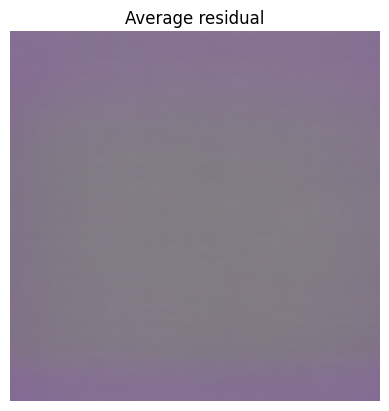

In [3]:
avg_residual_1 = cv2.imread('/content/residuals/avg_residual_1.png')
avg_residual_2 = cv2.imread('/content/residuals/avg_residual_2.png')

residual = torch.Tensor(2,512,512,3)
residual[0] = torch.Tensor(avg_residual_1)
residual[1] = torch.Tensor(avg_residual_2)



avg_residual = torch.mean(residual,dim=0).type(torch.uint8)

plt.title("Average residual")
plt.axis("off")
plt.imshow(avg_residual)

R_mean = torch.mean(avg_residual.type(torch.float32)[:,:,0])
G_mean = torch.mean(avg_residual.type(torch.float32)[:,:,1])
B_mean = torch.mean(avg_residual.type(torch.float32)[:,:,2])

R_std = torch.std(avg_residual.type(torch.float32)[:,:,0])
G_std = torch.std(avg_residual.type(torch.float32)[:,:,1])
B_std = torch.std(avg_residual.type(torch.float32)[:,:,2])

print("R_mean: {}\tR_std: {}\nG_mean: {}\tG_std: {}\nB_mean: {}\tB_std: {}".format(R_mean,R_std,G_mean,G_std,B_mean,B_std))